## Testing metacal gradients

In [1]:
import numpy as np
import ngmix
import galsim
import autometacal

from numpy.testing import assert_allclose

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
# Generate some data, any old data will do
def make_data(rng, noise, shear):
    """
    simulate an exponential object with moffat psf
    Parameters
    ----------
    rng: np.random.RandomState
        The random number generator
    noise: float
        Noise for the image
    shear: (g1, g2)
        The shear in each component
    Returns
    -------
    ngmix.Observation
    """

    psf_noise = 1.0e-6

    scale = 0.263
    stamp_size = 45
    psf_fwhm = 0.9
    gal_hlr = 0.5
    dy, dx = rng.uniform(low=-scale/2, high=scale/2, size=2)

    psf = galsim.Moffat(
        beta=2.5, fwhm=psf_fwhm,
    ).shear(
        g1=0.0,
        g2=0.0,
    )

    obj0 = galsim.Exponential(
        half_light_radius=gal_hlr,
    ).shear(
        g1=shear[0],
        g2=shear[1],
    ).shift(
        dx=dx,
        dy=dy,
    )

    obj = galsim.Convolve(psf, obj0)

    psf_im = psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array
    im = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array

    psf_im += rng.normal(scale=psf_noise, size=psf_im.shape)
    im += rng.normal(scale=noise, size=im.shape)

    cen = (np.array(im.shape))/2.0
    psf_cen = (np.array(psf_im.shape))/2.0

    jacobian = ngmix.DiagonalJacobian(
        row=cen[0], col=cen[1], scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )

    wt = im*0 + 1.0/noise**2
    psf_wt = psf_im*0 + 1.0/psf_noise**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )

    obs = ngmix.Observation(
        im,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )

    return obs

In [141]:
args={'seed':31415,
      'ntrial':1000,
      'noise': 1e-5,
      'psf': 'gauss'}
shear_true = [0.0, 0.00]
rng = np.random.RandomState(args['seed'])

In [142]:
obs = make_data(rng=rng, noise=args['noise'], shear=shear_true)
# We will measure moments with a fixed gaussian weight function
weight_fwhm = 1.2
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner = ngmix.runners.Runner(fitter=fitter)

boot = ngmix.metacal.MetacalBootstrapper(
runner=runner, psf_runner=psf_runner,
rng=rng,
psf=args['psf'],
step=0.01,
fixnoise=False
)
# Run metacal
resdict, obsdict = boot.go(obs)

# Run autometacal
im = obs.image.reshape(1,45,45).astype('float32')
psf = obs.psf.image.reshape(1,45,45).astype('float32') 
rpsf = obsdict['noshear'].psf.image.reshape(1,45,45).astype('float32') 

mcal = autometacal.generate_mcal_image(im.repeat(3,0), 
                                     psf.repeat(3,0), 
                                     rpsf.repeat(3,0), 
                                     np.array([[0,0],
                                               [0.01,0],
                                               [0,0.01]]).astype('float32'))

In [14]:
# Now with autodiff
import tensorflow as tf

In [15]:
g = tf.zeros([1,2])

with tf.GradientTape() as tape:
    tape.watch(g)
    mcal = autometacal.generate_mcal_image(im, 
                                     psf, 
                                     rpsf, 
                                     g)
res_autodiff= tape.batch_jacobian(mcal, g)

In [16]:
def shearing_fn(g):
    mcal = autometacal.generate_mcal_image(im, 
                                     psf, 
                                     rpsf, 
                                     np.array([[g[0], g[1]]]).astype('float32'))
    
    return mcal.numpy().flatten()

In [22]:
# Evaluating gradients with numdifftools
import numdifftools

jac= numdifftools.Jacobian(shearing_fn, step=0.001)
res = jac(np.zeros([2])).reshape([45,45,2])

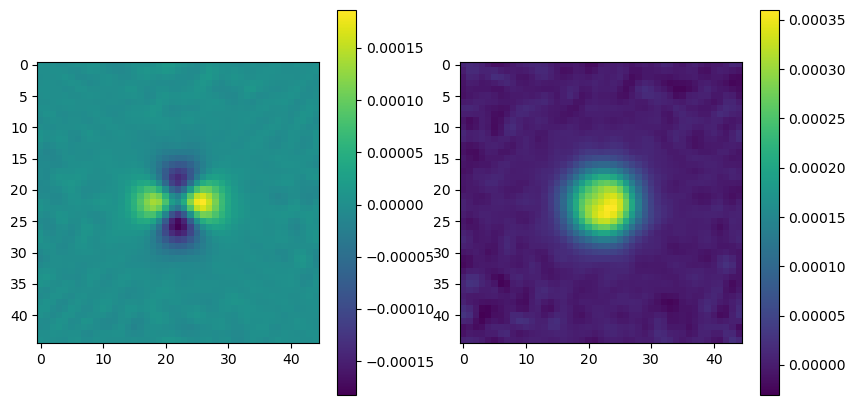

In [18]:
# Step size 0.01
figure(figsize=[10,5])
subplot(121)
imshow(res_autodiff[0,:,:,0] - res[:,:,0]); colorbar()
subplot(122)
imshow(res_autodiff[0,:,:,1] - res[:,:,1]); colorbar()

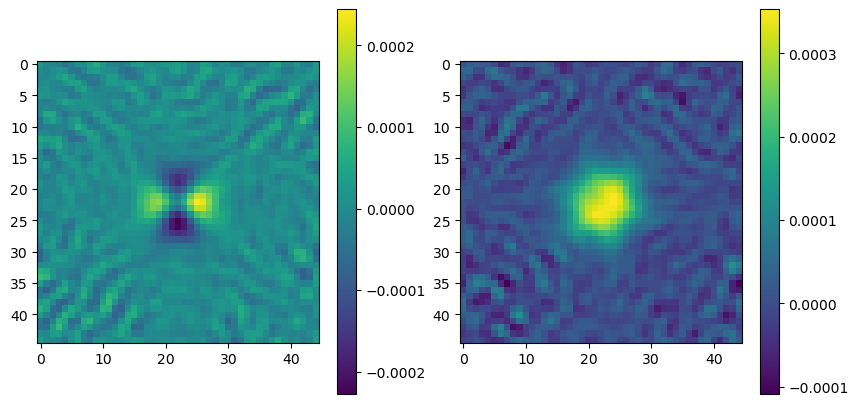

In [21]:
# Step size 0.1
figure(figsize=[10,5])
subplot(121)
imshow(res_autodiff[0,:,:,0] - res[:,:,0]); colorbar()
subplot(122)
imshow(res_autodiff[0,:,:,1] - res[:,:,1]); colorbar()

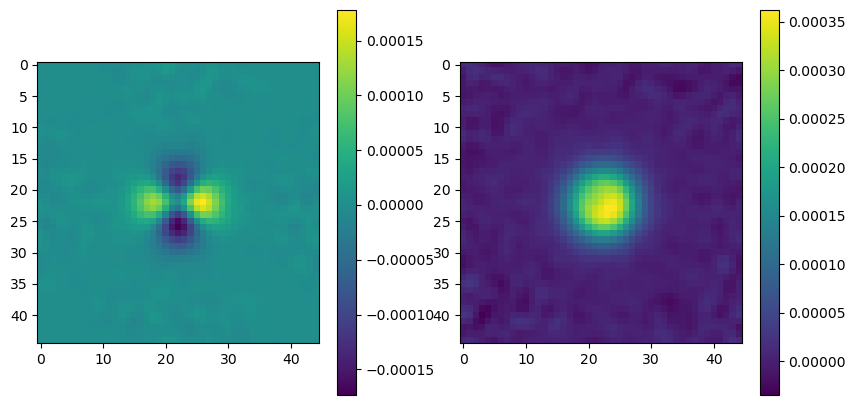

In [23]:
# Step size 0.001
figure(figsize=[10,5])
subplot(121)
imshow(res_autodiff[0,:,:,0] - res[:,:,0]); colorbar()
subplot(122)
imshow(res_autodiff[0,:,:,1] - res[:,:,1]); colorbar()

In [71]:
# Ok, so there is apparently a problem with gradients. Most likely source 
# of error would be the shearing step

In [24]:
import galflow as gf

In [25]:
im = tf.reshape(im, [1,45,45,1])
y = gf.shear(im, g[:,0], g[:,1])

In [26]:
g = tf.zeros([1,2])

with tf.GradientTape() as tape:
    tape.watch(g)
    y = gf.shear(im, g[:,0], g[:,1] )
    
res_autodiff= tape.batch_jacobian(y, g)

In [27]:
def shear_fn(g):
    g = g.reshape([1,2]).astype('float32')
    g = tf.convert_to_tensor(g)
    y = gf.shear(im, g[:,0], g[:,1])
    return y.numpy().flatten()

In [28]:
jac= numdifftools.Jacobian(shear_fn, order=4, step=0.001)
res = jac(np.zeros([2])).reshape([45,45,2])

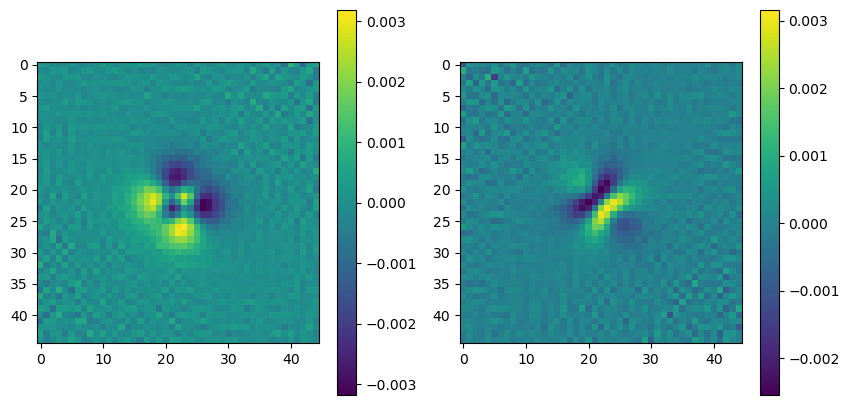

In [30]:
# Step size 0.001
figure(figsize=[10,5])
subplot(121)
imshow(res_autodiff[0,:,:,0,0] - res[:,:,0]); colorbar()
subplot(122)
imshow(res_autodiff[0,:,:,0,1] - res[:,:,1]); colorbar()

In [39]:
# Hum let's try the same thing with even size image

In [40]:
im = im[:,:44,:44,:]

In [33]:
g = tf.zeros([1,2])

with tf.GradientTape() as tape:
    tape.watch(g)
    y = gf.shear(im, g[:,0], g[:,1] )
    
res_autodiff= tape.batch_jacobian(y, g)

In [34]:
def shear_fn(g):
    g = g.reshape([1,2]).astype('float32')
    g = tf.convert_to_tensor(g)
    y = gf.shear(im, g[:,0], g[:,1])
    return y.numpy().flatten()

In [37]:
jac= numdifftools.Jacobian(shear_fn, order=4, step=0.01)
res = jac(np.zeros([2])).reshape([44,44,2])

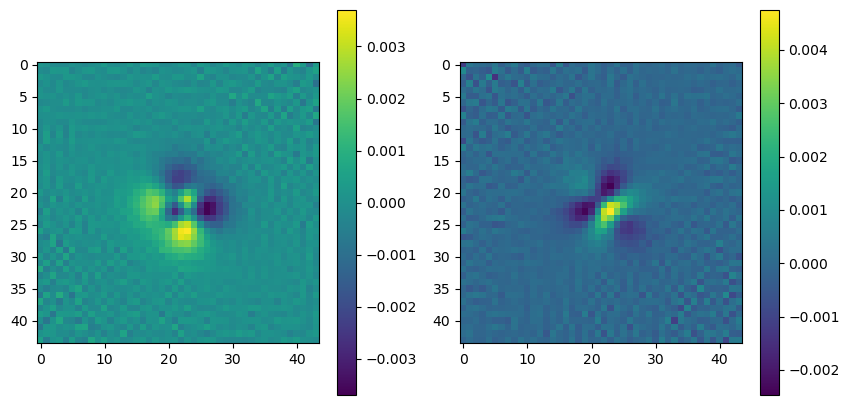

In [38]:
# Step size 0.01
figure(figsize=[10,5])
subplot(121)
imshow(res_autodiff[0,:,:,0,0] - res[:,:,0]); colorbar()
subplot(122)
imshow(res_autodiff[0,:,:,0,1] - res[:,:,1]); colorbar()

ok, so, looks like our interpolation goes bonkers, let's try to validate the gradients of tfa resampler directly

## Checking gradient of the jacobian

In [55]:
g = tf.zeros([1,2])

with tf.GradientTape() as tape:
    tape.watch(g)
    j = gf.shear_transformation(g[:,0],g[:,1])
    
res_autodiff= tape.batch_jacobian(j, g)

In [59]:
res_autodiff[0,:,:,1]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0., -1.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  0.,  0.]], dtype=float32)>

In [60]:
def fn(g):
    g = g.reshape([1,2]).astype('float32')
    g = tf.convert_to_tensor(g)
    j = gf.shear_transformation(g[:,0],g[:,1])
    return j.numpy().flatten()

In [62]:
jac= numdifftools.Jacobian(fn, order=4, step=0.01)
res = jac(np.zeros([2])).reshape([3,3,2])

In [65]:
res[:,:,0], res_autodiff[0,:,:,0]

(array([[-0.99999659,  0.        ,  0.        ],
        [ 0.        ,  0.99999659,  0.        ],
        [ 0.        ,  0.        ,  0.        ]]),
 <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[-1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  0.]], dtype=float32)>)

In [66]:
res[:,:,1], res_autodiff[0,:,:,1]

(array([[ 0.        , -0.99999975,  0.        ],
        [-0.99999975,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]]),
 <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[ 0., -1.,  0.],
        [-1.,  0.,  0.],
        [ 0.,  0.,  0.]], dtype=float32)>)

## Checking gradients of the warp function

In [69]:
from galflow.python.tfutils.transformer import *

In [70]:
def perspective_transform(
    image,
    transform_matrix,
    output_shape = None,
    resampling_type = ResamplingType.BILINEAR,
    border_type = BorderType.ZERO,
    pixel_type = PixelType.HALF_INTEGER,
    name = "perspective_transform",
):
  """Applies a projective transformation to an image.
  The projective transformation is represented by a 3 x 3 matrix
  [[a0, a1, a2], [b0, b1, b2], [c0, c1, c2]], mapping a point `[x, y]` to a
  transformed point
  `[x', y'] = [(a0 x + a1 y + a2) / k, (b0 x + b1 y + b2) / k]`, where
  `k = c0 x + c1 y + c2`.
  Note:
      The transformation matrix maps target to source by transforming output
      points to input points.
  Args:
    image: A tensor of shape `[B, H_i, W_i, C]`, where `B` is the batch size,
      `H_i` the height of the image, `W_i` the width of the image, and `C` the
      number of channels of the image.
    transform_matrix: A tensor of shape `[B, 3, 3]` containing projective
      transform matrices. The transformation maps target to source by
      transforming output points to input points.
    output_shape: The heigh `H_o` and width `W_o` output dimensions after the
      transform. If None, output is the same size as input image.
    resampling_type: Resampling mode. Supported values are
      `ResamplingType.NEAREST` and `ResamplingType.BILINEAR`.
    border_type: Border mode. Supported values are `BorderType.ZERO` and
      `BorderType.DUPLICATE`.
    pixel_type: Pixel mode. Supported values are `PixelType.INTEGER` and
      `PixelType.HALF_INTEGER`.
    name: A name for this op. Defaults to "perspective_transform".
  Returns:
    A tensor of shape `[B, H_o, W_o, C]` containing transformed images.
  Raises:
    ValueError: If `image` has rank != 4. If `transform_matrix` has rank < 3 or
    its last two dimensions are not 3. If `image` and `transform_matrix` batch
    dimension does not match.
  """
  with tf.name_scope(name):
    image = tf.convert_to_tensor(value=image, name="image")
    transform_matrix = tf.convert_to_tensor(
        value=transform_matrix, name="transform_matrix")
    output_shape = tf.shape(
        input=image)[-3:-1] if output_shape is None else tf.convert_to_tensor(
            value=output_shape, name="output_shape")
    dtype = image.dtype
    zero = tf.cast(0.0, dtype)
    height, width = tf.unstack(output_shape, axis=-1)
    warp = generate(
        starts=(zero, zero),
        stops=(tf.cast(width, dtype) - 1.0, tf.cast(height, dtype) - 1.0),
        nums=(width, height))
    warp = tf.transpose(a=warp, perm=[1, 0, 2])

    if pixel_type == PixelType.HALF_INTEGER:
      warp += 0.5

    padding = [[0, 0] for _ in range(warp.shape.ndims)]
    padding[-1][-1] = 1
    warp = tf.pad(
        tensor=warp, paddings=padding, mode="CONSTANT", constant_values=1.0)

    warp = warp[..., tf.newaxis]
    transform_matrix = transform_matrix[:, tf.newaxis, tf.newaxis, ...]
    warp = tf.linalg.matmul(transform_matrix, warp)
    warp = warp[..., 0:2, 0] / warp[..., 2, :]

    return warp

In [75]:
g = tf.zeros([1,2])

with tf.GradientTape() as tape:
    tape.watch(g)
    j = gf.shear_transformation(g[:,0],g[:,1])
    w = perspective_transform(im, j)

res_autodiff= tape.batch_jacobian(w, g)

In [78]:
def fn(g):
    g = g.reshape([1,2]).astype('float32')
    g = tf.convert_to_tensor(g)
    j = gf.shear_transformation(g[:,0],g[:,1])
    w = perspective_transform(im, j)
    return w.numpy().flatten()

In [92]:
jac= numdifftools.Jacobian(fn, order=4, step=0.001)
res = jac(np.zeros([2])).reshape([44,44,2,2])

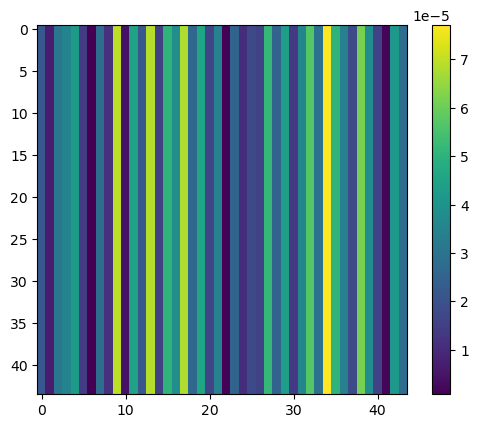

In [101]:
ind1=0;ind2=0
imshow(abs(res[:,:,ind1,ind2] - res_autodiff[0,:,:,ind1,ind2])/abs(res_autodiff[0,:,:,ind1,ind2])); colorbar()

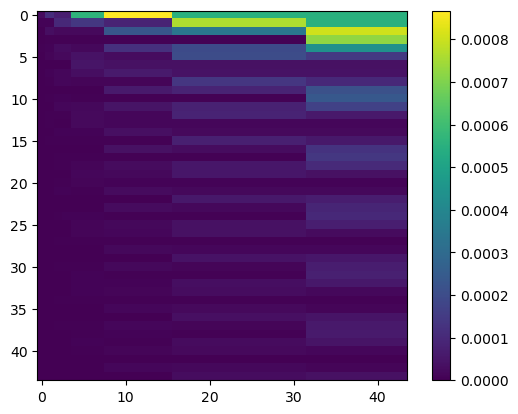

In [102]:
ind1=0;ind2=1
imshow(abs(res[:,:,ind1,ind2] - res_autodiff[0,:,:,ind1,ind2])/abs(res_autodiff[0,:,:,ind1,ind2])); colorbar()

## Checking gradients of resampler

In [168]:
im = obs.image.reshape(1,45,45).astype('float32')
im = tf.reshape(im, [1,45,45,1])
g = tf.zeros([1,2])


# offset in pixels
offset = 0.5

with tf.GradientTape() as tape:
    tape.watch(g)
    j = gf.shear_transformation(g[:,0],g[:,1])
    w = perspective_transform(im, j)
    w = w - offset
    y = tfa_image.resampler(im, w)

res_autodiff= tape.batch_jacobian(y, g)

In [169]:
def fn(g):
    g = g.reshape([1,2]).astype('float32')
    j = gf.shear_transformation(g[:,0],g[:,1])
    w = perspective_transform(im, j)
    w = w - offset
    y = tfa_image.resampler(im, w)
    return y.numpy().flatten()

In [170]:
jac= numdifftools.Jacobian(fn, order=4, step=0.001)
res = jac(np.zeros([2])).reshape([45,45,2])

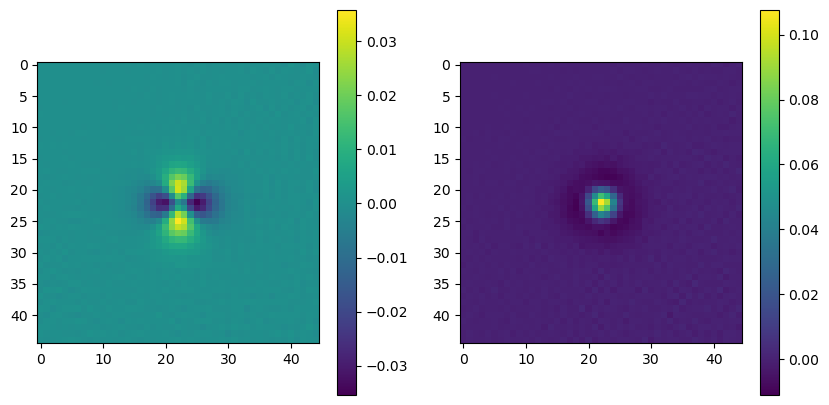

In [171]:
# Step size 0.001
figure(figsize=[10,5])
subplot(121)
imshow(res_autodiff[0,:,:,0,0] - res[:,:,0]); colorbar()
subplot(122)
imshow(res_autodiff[0,:,:,0,1] - res[:,:,1]); colorbar()